# Plotting timeseries of ice mass export through gates

* **Description**: Plots historical and future timeseries by month and gate
* **Input data**: Processed rufmod and cesm2-le netcdf files
* **Output data**: Timeseries plots in png format
* **Creator**: Alice DuVivier
* **Date**: February 2022

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
import glob
import dask
from matplotlib.gridspec import GridSpec
import pandas as pd
from scipy.stats import ttest_ind


## Read in the processed data

This reads in pre-processed fluxes of snow and ice through gates at Fram Strait, Barents Sea, and Bering Strait.

The mass is snow+ice and is in kg/s


In [2]:
# set base directory where all data live
data_dir = '/glade/p/cgd/ppc/duvivier/cesm2_arctic_cyclones/rufmod_analysis/version_5/fig_7_ice_export_flux_gates/'

# set file names
fin_le = 'CESM2-LE_mass_fluxes'
fin_smooth = 'rufmod_mass_fluxes'

In [3]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
len(month_names)

12

In [4]:
ds_le = xr.open_dataset(data_dir+fin_le+'.nc',decode_times=True)
ds_smooth = xr.open_dataset(data_dir+fin_smooth+'.nc',decode_times=True)

In [5]:
# double check that year/month is not shifted incorrectly
ds_le.coords['time.month']
ds_smooth.coords['time.month']

<xarray.DataArray 'month' (time: 1032)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [6]:
# Gates we want
regions = ['fram','barents','arcoc','bering']

In [7]:
# check gates - should be fram, barents, bering
ds_le

<xarray.Dataset>
Dimensions:       (member_id: 50, time: 1032)
Coordinates:
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'
Data variables:
    flux_fram     (member_id, time) float32 ...
    flux_barents  (member_id, time) float32 ...
    flux_arcoc    (member_id, time) float32 ...
    flux_bering   (member_id, time) float32 ...
Attributes:
    Author:    Alice DuVivier
    units:     kg/s
    longname:  total snow and sea ice mass transport through gate

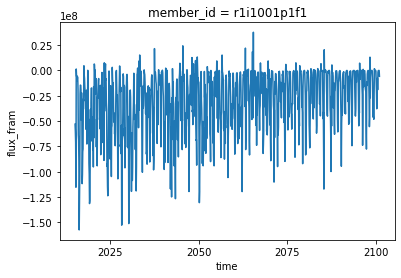

In [8]:
# just check the data to be sure it's working
ds_le['flux_fram'].sel(member_id='r1i1001p1f1').plot()

In [9]:
# check gates - should be fram, barents, bering
ds_smooth

<xarray.Dataset>
Dimensions:       (member_id: 5, time: 1032)
Coordinates:
  * time          (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Data variables:
    flux_fram     (member_id, time) float32 ...
    flux_barents  (member_id, time) float32 ...
    flux_arcoc    (member_id, time) float32 ...
    flux_bering   (member_id, time) float32 ...
Attributes:
    Author:    Alice DuVivier
    units:     kg/s
    longname:  total snow and sea ice mass transport through gate

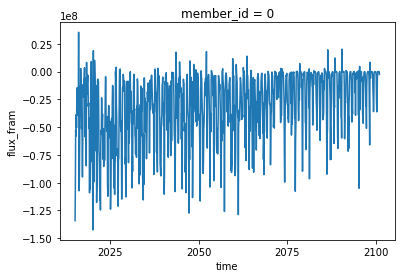

In [10]:
# just check the data to be sure it's working
ds_smooth['flux_fram'].sel(member_id=0).plot()

In [11]:
label = ds_le.longname
units = ds_le.units

print(label)
print(units)

total snow and sea ice mass transport through gate
kg/s


In [12]:
# convert to 1000000's of km3
ds_le = ds_le/(1000000.0)
ds_smooth = ds_smooth/(1000000.0)
units = '($10^{6}$ kg $s^{-1}$)'

In [13]:
# set the different gates
fram_le = ds_le['flux_fram']
fram_smooth = ds_smooth['flux_fram']
barents_le = ds_le['flux_barents']
barents_smooth = ds_smooth['flux_barents']
arcoc_le = ds_le['flux_arcoc']
arcoc_smooth = ds_smooth['flux_arcoc']
bering_le = ds_le['flux_bering']
bering_smooth = ds_smooth['flux_bering']

## Calculate seasonal means

In [14]:
season_names = ['ANN']

In [15]:
# find total years
xarr_le = fram_le.coords['time.year'][(fram_le.coords['time.month']==1)]
xarr_smooth = fram_smooth.coords['time.year'][(fram_smooth.coords['time.month']==1)]

In [16]:
fram_le.isel(time=fram_le.time.dt.month.isin([1,2,3]))

<xarray.DataArray 'flux_fram' (member_id: 50, time: 258)>
array([[ -70.392365 ,  -34.601753 ,  -44.924156 , ...,  -25.286484 ,
         -45.343143 ,   -8.930609 ],
       [ -59.296524 ,  -11.472379 ,  -98.78612  , ...,  -10.809101 ,
         -15.620744 ,  -56.474358 ],
       [ -83.3116   ,  -79.28732  ,  -60.90802  , ...,   -6.4282107,
          -9.157944 ,  -14.128658 ],
       ...,
       [ -78.29906  ,  -74.691864 , -114.56396  , ...,  -13.893386 ,
         -16.376295 ,  -37.714924 ],
       [ -83.79164  , -100.25872  , -101.108955 , ...,  -14.437912 ,
         -41.930916 ,  -25.734835 ],
       [ -64.57366  , -109.265305 , -146.05873  , ...,   -9.712085 ,
         -31.591597 ,  -46.65937  ]], dtype=float32)
Coordinates:
  * time       (time) object 2015-01-16 12:00:00 ... 2100-03-16 12:00:00
  * member_id  (member_id) object 'r10i1181p1f1' ... 'r9i1301p1f1'

In [17]:
# Loop through seasons - rufmod
print('Calculating Annual Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
fram_seas_array_smooth = np.zeros([len(fram_smooth.member_id),len(xarr_smooth)])
barents_seas_array_smooth = np.zeros([len(fram_smooth.member_id),len(xarr_smooth)])
arcoc_seas_array_smooth = np.zeros([len(fram_smooth.member_id),len(xarr_smooth)])
bering_seas_array_smooth = np.zeros([len(fram_smooth.member_id),len(xarr_smooth)])

# now loop through years to get the seasonal average by year for each ensemble member
for yy in xarr_smooth:
    if yy == 2015:
        y_count = 0
    else: 
        y_count = y_count+1 
    # select only the indexes for this year
    temp = fram_smooth.isel(time=fram_smooth.time.dt.year.isin([yy]))
    fram_seas_array_smooth[:,y_count] = temp.mean(dim='time')
        
    temp = barents_smooth.isel(time=barents_smooth.time.dt.year.isin([yy]))
    barents_seas_array_smooth[:,y_count] = temp.mean(dim='time')
        
    temp = arcoc_smooth.isel(time=arcoc_smooth.time.dt.year.isin([yy]))
    arcoc_seas_array_smooth[:,y_count] = temp.mean(dim='time')
        
    temp = bering_smooth.isel(time=bering_smooth.time.dt.year.isin([yy]))
    bering_seas_array_smooth[:,y_count] = temp.mean(dim='time')
        

Calculating Annual Means - SMOOTH


In [18]:
# Loop through seasons - rufmod
print('Calculating Annual Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
fram_seas_array_le = np.zeros([len(fram_le.member_id),len(xarr_le)])
barents_seas_array_le = np.zeros([len(fram_le.member_id),len(xarr_le)])
arcoc_seas_array_le = np.zeros([len(fram_le.member_id),len(xarr_le)])
bering_seas_array_le = np.zeros([len(fram_le.member_id),len(xarr_le)])

# now loop through years to get the seasonal average by year for each ensemble member
for yy in xarr_le:
    if yy == 2015:
        y_count = 0
    else: 
        y_count = y_count+1 
    # select only the indexes for this year
    temp = fram_le.isel(time=fram_le.time.dt.year.isin([yy]))
    fram_seas_array_le[:,y_count] = temp.mean(dim='time')
        
    temp = barents_le.isel(time=barents_le.time.dt.year.isin([yy]))
    barents_seas_array_le[:,y_count] = temp.mean(dim='time')
        
    temp = arcoc_le.isel(time=arcoc_le.time.dt.year.isin([yy]))
    arcoc_seas_array_le[:,y_count] = temp.mean(dim='time')
        
    temp = bering_le.isel(time=bering_le.time.dt.year.isin([yy]))
    bering_seas_array_le[:,y_count] = temp.mean(dim='time')
        

Calculating Annual Means - CESM2-LE


In [19]:
print(fram_seas_array_le.shape)
print(fram_seas_array_smooth.shape)

(50, 86)
(5, 86)


In [20]:
# convert the numpy array to a xarray
fram_seas_le = xr.DataArray(fram_seas_array_le,dims=('member_id','time'))
fram_seas_smooth = xr.DataArray(fram_seas_array_smooth,dims=('member_id','time'))

barents_seas_le = xr.DataArray(barents_seas_array_le,dims=('member_id','time'))
barents_seas_smooth = xr.DataArray(barents_seas_array_smooth,dims=('member_id','time'))

arcoc_seas_le = xr.DataArray(arcoc_seas_array_le,dims=('member_id','time'))
arcoc_seas_smooth = xr.DataArray(arcoc_seas_array_smooth,dims=('member_id','time'))

bering_seas_le = xr.DataArray(bering_seas_array_le,dims=('member_id','time'))
bering_seas_smooth = xr.DataArray(bering_seas_array_smooth,dims=('member_id','time'))


In [21]:
# set coordinate arrays
fram_seas_le['time'] = xarr_le
fram_seas_le['member_id'] = fram_le['member_id']

fram_seas_smooth['time'] = xarr_smooth
fram_seas_smooth['member_id'] = fram_smooth['member_id']

barents_seas_le['time'] = xarr_le
barents_seas_le['member_id'] = fram_le['member_id']

barents_seas_smooth['time'] = xarr_smooth
barents_seas_smooth['member_id'] = fram_smooth['member_id']

arcoc_seas_le['time'] = xarr_le
arcoc_seas_le['member_id'] = fram_le['member_id']

arcoc_seas_smooth['time'] = xarr_smooth
arcoc_seas_smooth['member_id'] = fram_smooth['member_id']

bering_seas_le['time'] = xarr_le
bering_seas_le['member_id'] = fram_le['member_id']

bering_seas_smooth['time'] = xarr_smooth
bering_seas_smooth['member_id'] = fram_smooth['member_id']

## Calculate ensemble means & significance

In [22]:
# calculate ensemble means
fram_seas_ens_mean_le = fram_seas_le.mean(dim='member_id')
fram_seas_ens_mean_smooth = fram_seas_smooth.mean(dim='member_id')

barents_seas_ens_mean_le = barents_seas_le.mean(dim='member_id')
barents_seas_ens_mean_smooth = barents_seas_smooth.mean(dim='member_id')

arcoc_seas_ens_mean_le = arcoc_seas_le.mean(dim='member_id')
arcoc_seas_ens_mean_smooth = arcoc_seas_smooth.mean(dim='member_id')

bering_seas_ens_mean_le = bering_seas_le.mean(dim='member_id')
bering_seas_ens_mean_smooth = bering_seas_smooth.mean(dim='member_id')

In [23]:
# calculate statistical significance
sigval = 0.05

# calculate statistical significance
tval,pval = ttest_ind(fram_seas_le,fram_seas_smooth,axis=0,equal_var=False)
fram_seas_ens_mean_le_sig = fram_seas_ens_mean_le.where(pval <= sigval)
fram_seas_ens_mean_smooth_sig = fram_seas_ens_mean_smooth.where(pval <= sigval)

tval,pval = ttest_ind(barents_seas_le,barents_seas_smooth,axis=0,equal_var=False)
barents_seas_ens_mean_le_sig = barents_seas_ens_mean_le.where(pval <= sigval)
barents_seas_ens_mean_smooth_sig = barents_seas_ens_mean_smooth.where(pval <= sigval)

tval,pval = ttest_ind(arcoc_seas_le,arcoc_seas_smooth,axis=0,equal_var=False)
arcoc_seas_ens_mean_le_sig = arcoc_seas_ens_mean_le.where(pval <= sigval)
arcoc_seas_ens_mean_smooth_sig = arcoc_seas_ens_mean_smooth.where(pval <= sigval)

tval,pval = ttest_ind(bering_seas_le,bering_seas_smooth,axis=0,equal_var=False)
bering_seas_ens_mean_le_sig = bering_seas_ens_mean_le.where(pval <= sigval)
bering_seas_ens_mean_smooth_sig = bering_seas_ens_mean_smooth.where(pval <= sigval)

In [24]:
# bootstrap the CESM2-LE 1000 times
n_bs=1000
fram_seas_bs_array_le = np.zeros([len(xarr_le),n_bs])
barents_seas_bs_array_le = np.zeros([len(xarr_le),n_bs])
arcoc_seas_bs_array_le = np.zeros([len(xarr_le),n_bs])
bering_seas_bs_array_le = np.zeros([len(xarr_le),n_bs])

for ii in range(n_bs):
    # choose random ensemble member numbers
    mem1=np.random.choice(range(0,49))
    mem2=np.random.choice(range(0,49))
    mem3=np.random.choice(range(0,49))
    mem4=np.random.choice(range(0,49))
    mem5=np.random.choice(range(0,49)) 
    # now average those random ensembles
    temp = np.stack((fram_seas_le.isel(member_id=mem1),fram_seas_le.isel(member_id=mem2),fram_seas_le.isel(member_id=mem3),
                     fram_seas_le.isel(member_id=mem4),fram_seas_le.isel(member_id=mem5)),axis=-1)
    fram_seas_bs_array_le[:,ii]=np.mean(temp,axis=1)
    
    temp = np.stack((barents_seas_le.isel(member_id=mem1),barents_seas_le.isel(member_id=mem2),barents_seas_le.isel(member_id=mem3),
                     barents_seas_le.isel(member_id=mem4),barents_seas_le.isel(member_id=mem5)),axis=-1)
    barents_seas_bs_array_le[:,ii]=np.mean(temp,axis=1)

    temp = np.stack((arcoc_seas_le.isel(member_id=mem1),arcoc_seas_le.isel(member_id=mem2),arcoc_seas_le.isel(member_id=mem3),
                     arcoc_seas_le.isel(member_id=mem4),arcoc_seas_le.isel(member_id=mem5)),axis=-1)
    arcoc_seas_bs_array_le[:,ii]=np.mean(temp,axis=1)
    
    temp = np.stack((bering_seas_le.isel(member_id=mem1),bering_seas_le.isel(member_id=mem2),bering_seas_le.isel(member_id=mem3),
                     bering_seas_le.isel(member_id=mem4),bering_seas_le.isel(member_id=mem5)),axis=-1)
    bering_seas_bs_array_le[:,ii]=np.mean(temp,axis=1)
    

In [25]:
fram_seas_bs_array_le.shape

(86, 1000)

In [26]:
# convert the numpy array to a xarray for easier plotting
fram_seas_bs_le = xr.DataArray(fram_seas_bs_array_le,dims=('time','bootstrap_num'))
barents_seas_bs_le = xr.DataArray(barents_seas_bs_array_le,dims=('time','bootstrap_num'))
arcoc_seas_bs_le = xr.DataArray(arcoc_seas_bs_array_le,dims=('time','bootstrap_num'))
bering_seas_bs_le = xr.DataArray(bering_seas_bs_array_le,dims=('time','bootstrap_num'))

In [27]:
# assign coordinate arrays
fram_seas_bs_le['time']= fram_seas_le.time

barents_seas_bs_le['time']= fram_seas_le.time

arcoc_seas_bs_le['time']= fram_seas_le.time

bering_seas_bs_le['time']= fram_seas_le.time

### Plotting!

In [28]:
#set some labeling info for plots
out_tag = 'ice_mass_flux'
label = 'Ice Mass Flux'

Plotting timeseries for all regions 


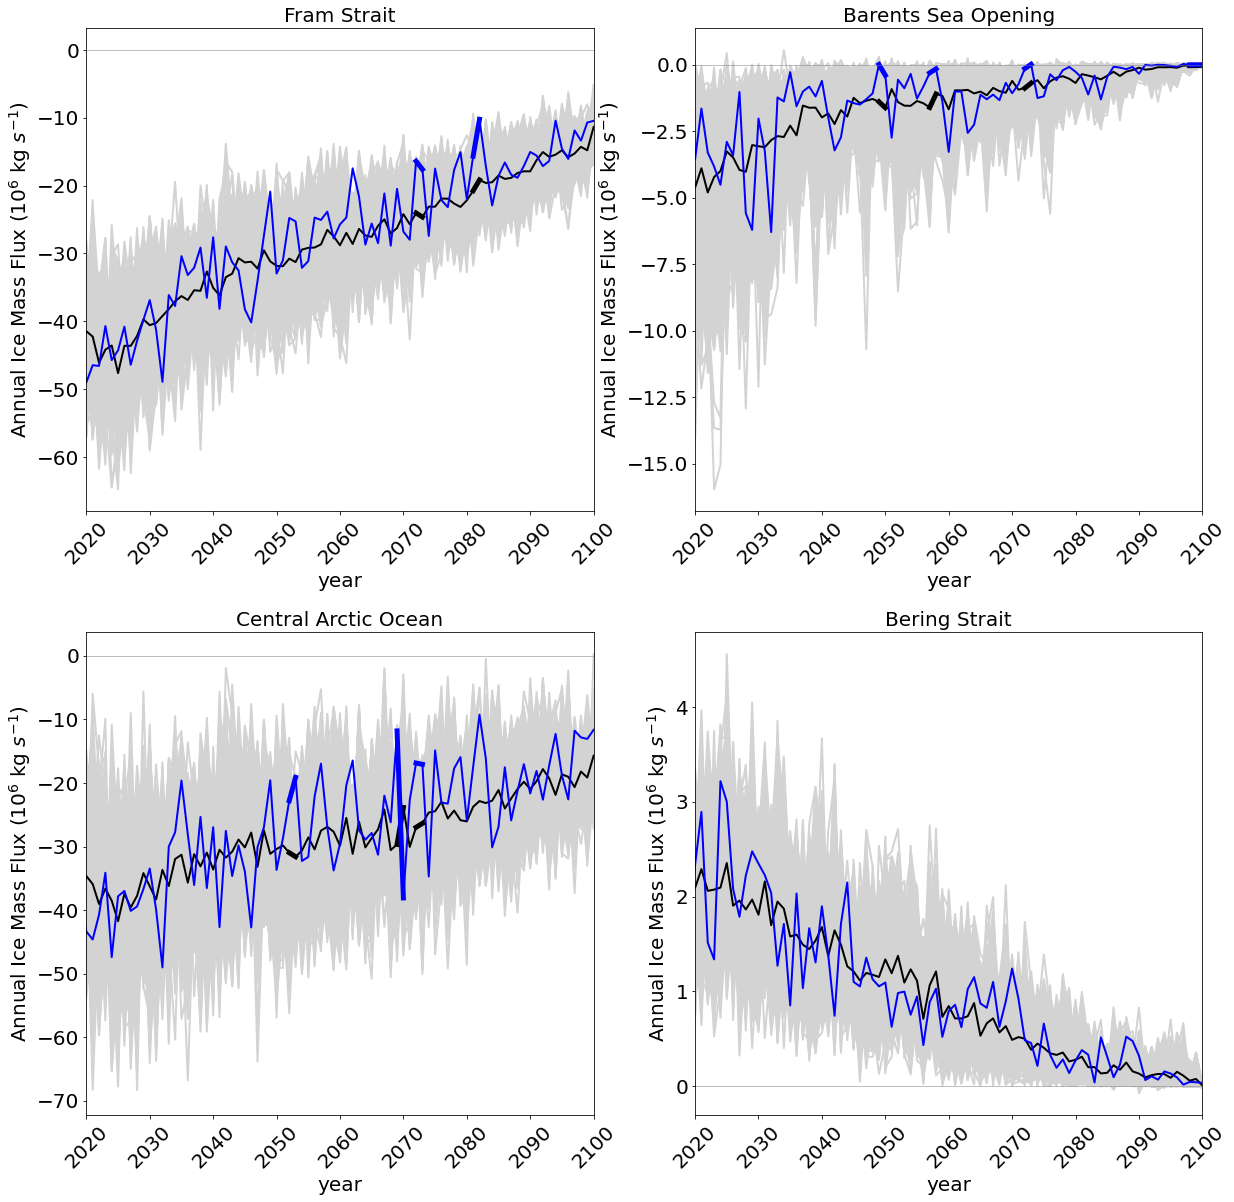

In [29]:
print('Plotting timeseries for all regions ')
# create figure
fig = plt.figure(figsize=(20,20))
fout = 'fig_7_'+out_tag+'_timeseries_all_seasons'

# Make subplot - note it's nrow x ncol x index (starting upper left)

ax = fig.add_subplot(2,2,1) 
### Fram strait
# CESM2-LE: subset the data for this season
temp_le     = fram_seas_bs_le
temp_le_ens = fram_seas_ens_mean_le
temp_le_sig = fram_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = fram_seas_ens_mean_smooth
temp_smooth_sig = fram_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('Fram Strait' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=30)

ax = fig.add_subplot(2,2,2) 
### Barents sea
# CESM2-LE: subset the data for this season
temp_le     = barents_seas_bs_le
temp_le_ens = barents_seas_ens_mean_le
temp_le_sig = barents_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = barents_seas_ens_mean_smooth
temp_smooth_sig = barents_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('Barents Sea Opening' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=30)

ax = fig.add_subplot(2,2,3) 
### Central Arctic Ocean
# CESM2-LE: subset the data for this season
temp_le     = arcoc_seas_bs_le
temp_le_ens = arcoc_seas_ens_mean_le
temp_le_sig = arcoc_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = arcoc_seas_ens_mean_smooth
temp_smooth_sig = arcoc_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('Central Arctic Ocean' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=30)

ax = fig.add_subplot(2,2,4) 
### Bering Strait
# CESM2-LE: subset the data for this season
temp_le     = bering_seas_bs_le
temp_le_ens = bering_seas_ens_mean_le
temp_le_sig = bering_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = bering_seas_ens_mean_smooth
temp_smooth_sig = bering_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('Bering Strait' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=20)
        
# Finalize figure and save
#fig.suptitle('Ensemble mean terms for '+label+' through '+reg,fontsize=20, y=0.95)  
fig.subplots_adjust(wspace=0.2, hspace=0.25)
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
print('Plotting timeseries for all regions ')
# create figure
fig = plt.figure(figsize=(20,10))
fout = 'fig_7_'+out_tag+'_timeseries_all_seasons'

# Make subplot - note it's nrow x ncol x index (starting upper left)

ax = fig.add_subplot(1,2,1) 
### Central Arctic Ocean
# CESM2-LE: subset the data for this season
temp_le     = arcoc_seas_bs_le
temp_le_ens = arcoc_seas_ens_mean_le
temp_le_sig = arcoc_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = arcoc_seas_ens_mean_smooth
temp_smooth_sig = arcoc_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=1)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=1)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('a) Central Arctic Ocean' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=30)

ax = fig.add_subplot(1,2,2) 
### Bering Strait
# CESM2-LE: subset the data for this season
temp_le     = bering_seas_bs_le
temp_le_ens = bering_seas_ens_mean_le
temp_le_sig = bering_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = bering_seas_ens_mean_smooth
temp_smooth_sig = bering_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=1,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=1)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=1)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('b) Bering Strait' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
#plt.legend(ncol=1,fontsize=20)
        
# Finalize figure and save
#fig.suptitle('Ensemble mean terms for '+label+' through '+reg,fontsize=20, y=0.95)  
fig.subplots_adjust(wspace=0.2, hspace=0.25)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)

Plotting timeseries for all regions 


Plotting timeseries for all regions 


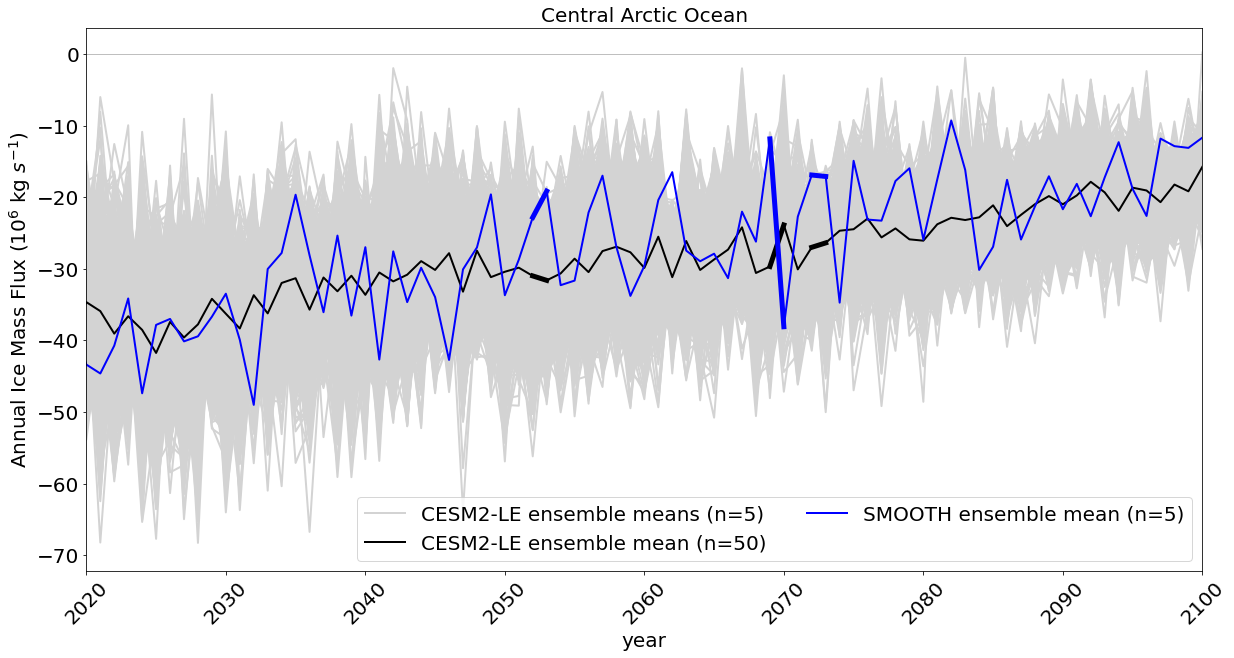

In [31]:
print('Plotting timeseries for all regions ')
# create figure
fig = plt.figure(figsize=(20,10))
fout = 'fig_7_legend'

# Make subplot - note it's nrow x ncol x index (starting upper left)

ax = fig.add_subplot(1,1,1) 
### Central Arctic Ocean
# CESM2-LE: subset the data for this season
temp_le     = arcoc_seas_bs_le
temp_le_ens = arcoc_seas_ens_mean_le
temp_le_sig = arcoc_seas_ens_mean_le_sig
        
# rufmod: subset the data for this season
temp_smooth_ens = arcoc_seas_ens_mean_smooth
temp_smooth_sig = arcoc_seas_ens_mean_smooth_sig
                       
# plot the bootstrapped means
for ii in range(n_bs):
    ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='_nolegend_');
ax.plot(xarr_le,temp_le[:,ii],color="lightgrey",linestyle='-',linewidth=2,label='CESM2-LE ensemble means (n=5)')
# plot ensemble means
ax.plot(xarr_le,temp_le_ens,label="CESM2-LE ensemble mean (n=50)",color='black',linestyle='-',linewidth=2)
ax.plot(xarr_smooth,temp_smooth_ens,label="SMOOTH ensemble mean (n=5)",color='blue',linestyle='-',linewidth=2)
# plot when ensemble means are significant
ax.plot(xarr_le,temp_le_sig,color='black',linestyle='-',linewidth=5,label='_nolegend_')
ax.plot(xarr_smooth,temp_smooth_sig,color='blue',linestyle='-',linewidth=5,label='_nolegend_')   

# finish up plot
plt.title('Central Arctic Ocean' ,fontsize=20)
plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20, rotation=45)
plt.xlim([2020,2100])
plt.ylabel('Annual Ice Mass Flux '+units,fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(ncol=2,fontsize=20,loc='lower right')
        
# Finalize figure and save
#fig.suptitle('Ensemble mean terms for '+label+' through '+reg,fontsize=20, y=0.95)  
#fig.subplots_adjust(wspace=0.2, hspace=0.25)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)